# How does compute scale? 

This uses pywren and the code from `flops_benchmark.ipynb` to test scaling of Lambda. See that notebook for more details. 


In [2]:
%pylab inline
import numpy as np
import time
import flops_benchmark
import pandas as pd
import pickle
import seaborn as sns
sns.set_style('whitegrid')
import glob


Populating the interactive namespace from numpy and matplotlib


We use the [ruffus pipeline manager](http://www.ruffus.org.uk/) to run a large number of jobs at varying scales. Each one generates a separate pickle file, which we will later load in. Note that running this many jobs with varying initial conditions can take a long time. 

In [4]:
!python run_many_experiments.py


________________________________________
Tasks which will be run:


Task enters queue = 'run_exp' 
invocation done, dur= 37.72882008552551
callset id:  0b1b2272-68b2-423a-b4dc-2dd558af6892
jobs done:     1    runtime: 241.5s        6.8 GFLOPS 
getting results
getting status
total time 241.51666045188904
6.8287936682220725 GFLOPS
invocation done, dur= 37.34835124015808
callset id:  8fb53356-3ab3-4616-9935-80357bba8d49
jobs done:     1    runtime: 241.3s        6.8 GFLOPS 
getting results
getting status
total time 241.333425283432
6.833978508062162 GFLOPS
invocation done, dur= 37.5164315700531
callset id:  0186e314-8109-4343-ad99-505bfe96e2f7
jobs done:     1    runtime: 236.5s        7.0 GFLOPS 
getting results
getting status
total time 236.51258659362793
6.973275568195212 GFLOPS
invocation done, dur= 37.52056169509888
callset id:  f82c7e8d-318e-4f26-8fe6-8f5a754181a5
jobs done:    30    runtime: 255.8s      193.5 GFLOPS 
getting results
getting status
total time 255.76150560379028
193

In [3]:
all_df = []
for filename in glob.glob("microbench.*.*.*.*.pickle"):
    exp_results = pickle.load(open(filename, 'rb'))
    exp_results['results'] = [x for x in exp_results['results'] if x is not None]
    results_df = flops_benchmark.results_to_dataframe(exp_results)
    results_df['filename'] = filename
    all_df.append(results_df)
all_df = pd.concat(all_df)

In [10]:
max_time = 1000
runtime_bins = np.linspace(0, max_time, max_time, endpoint=False)
    
filename_hists = {}
for fname, df in all_df.groupby('filename'):
    
    time_offset = np.min(df.host_submit_time)
    
    runtime_flops_hist = np.zeros((len(df), len(runtime_bins)))
    for i in range(len(df)):
        row = df.iloc[i]
        s = (row.start_time + row.setup_time) - time_offset
        e = row.end_time - time_offset
        a, b = np.searchsorted(runtime_bins, [s, e])
        if b-a > 0:
            runtime_flops_hist[i, a:b] = row.est_flops / float(b-a)
    filename_hists[fname] = runtime_flops_hist
    

In [11]:

peak_stats = []
for wi, (worker_count, d) in enumerate(all_df.groupby('workers')):
    for fname, df in d.groupby('filename'):
        agg_hist = filename_hists[fname].sum(axis=0)/1e12
        total_time = np.max(df.download_output_timestamp)- np.min(df.host_submit_time)
        total_tflops = np.sum(df.est_flops)/1e12
        ps = {'worker_count' : worker_count, 'filename' : fname, 
              'peak_TFLOPS' : np.max(agg_hist), 'effective_TFLOPS': total_tflops/total_time}
        peak_stats.append(ps)
peak_df = pd.DataFrame(peak_stats)


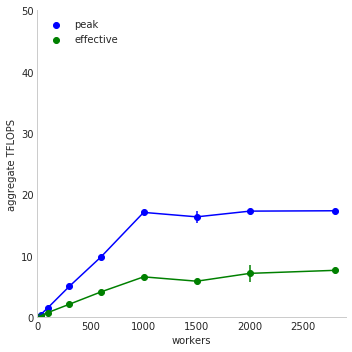

In [12]:
s = peak_df.groupby(['worker_count']).agg({'peak_TFLOPS' : ['mean', 'std', 'min', 'max'], 
                                           'effective_TFLOPS' : ['mean', 'std', 'min', 'max']}, 
                                         )
fig = pylab.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(s.index.values, s.peak_TFLOPS['mean'] ,c='b', label='peak')
ax.errorbar(np.array(s.index.values), np.array(s.peak_TFLOPS['mean']), 
            yerr=np.array(s.peak_TFLOPS['std']), ecolor='b', c='b', label=None)
ax.scatter(s.index.values, s.effective_TFLOPS['mean'] ,c='g', label='effective')
ax.errorbar(np.array(s.index.values), np.array(s.effective_TFLOPS['mean']),  c='g',
            yerr=np.array(s.effective_TFLOPS['std']), ecolor='g', label=None)
ax.grid(False)
ax.set_xlim(0, 2900)
ax.set_ylim(0, 50)
ax.set_xlabel('workers')
ax.set_ylabel('aggregate TFLOPS')
s.peak_TFLOPS['mean']

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left')
fig.tight_layout()
fig.savefig("flops_scaling.flops.png")


We'll make a small version of the plot for use elsewhere. 

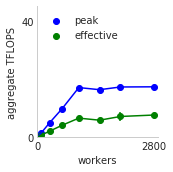

In [13]:
fig = pylab.figure(figsize=(2.5, 2.5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(s.index.values, s.peak_TFLOPS['mean'] ,c='b', label='peak')
ax.errorbar(np.array(s.index.values), np.array(s.peak_TFLOPS['mean']), 
            yerr=np.array(s.peak_TFLOPS['std']), ecolor='b', c='b', label=None)
ax.scatter(s.index.values, s.effective_TFLOPS['mean'] ,c='g', label='effective')
ax.errorbar(np.array(s.index.values), np.array(s.effective_TFLOPS['mean']),  c='g',
            yerr=np.array(s.effective_TFLOPS['std']), ecolor='g', label=None)
ax.grid(False)
#ax.set_xlim(0, 2900)
#ax.set_ylim(0, 50)
ax.set_xlabel('workers')
ax.set_ylabel('aggregate TFLOPS')
#s.peak_TFLOPS['mean']

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 2800])
ax.set_yticks([0, 40])
ax.set_xlim(0, 2900)
ax.set_ylim(0, 45)
ax.legend(loc='upper left')

fig.tight_layout()

fig.savefig("flops_scaling.flops.small.png")
